In [1]:
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np
import seaborn as sns
import cv2

#NN
import tensorflow as tf
from tensorflow import GradientTape
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

# Metrics
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# GPU
from tensorflow.python.client import device_lib

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dty

In [2]:
# Check GPU Detected
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12978442336070236801
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7129487770
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11865709595933488293
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Functions

In [3]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is%20not%20part%20of,each%20epoch,%20need%20to%20make%20some%20more%20efforts.
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [5]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [6]:
#https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
gamma = 2
alpha = .25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

## Grouping Files into Datasets

In [7]:
model_num = 3
base_path="C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/"
datasets = base_path + "MRI Data/WM parc data - cropped images/"
data = datasets + "ExpandedCrop_Square_Hist_NewSplit_OSampled/"
cross_val = datasets + "Blur_Contour_Expand_Crop-Cats_Combined/"

chosen_model = base_path + "Models/three-slice-data/VGG16_Fit_3slice_reg_OSampled_CV - 3_2/best_model_" + str(model_num) + ".hdf5"

In [8]:
# Break:
# 196 : 97 : 97
# 359 : 178 : 178

In [9]:
# Cross val dataset check
train_size = len(os.listdir(data + "1-Train/1-AD"))+len(os.listdir(data + "1-Train/0-CN"))
valid_size = len(os.listdir(data + "2-Validation/1-AD"))+len(os.listdir(data + "2-Validation/0-CN"))
test_size = len(os.listdir(data + "3-Test/1-AD"))+len(os.listdir(data + "3-Test/0-CN"))

cv_val_size = len(os.listdir(cross_val + "Cross_Val/1-AD"))+len(os.listdir(cross_val + "Cross_Val/0-CN"))
cv_test_size = len(os.listdir(cross_val + "Test/1-AD"))+len(os.listdir(cross_val + "Test/0-CN"))


print("Total Training Data: ", train_size)
print("Total Validation Data: ", valid_size)
print("Total Test Data: ", test_size)

print("\nTotal Cross Validation Data: ", cv_val_size)
print("Total Test Data: ", cv_test_size)

Total Training Data:  1146
Total Validation Data:  142
Total Test Data:  142

Total Cross Validation Data:  829
Total Test Data:  276


In [10]:
batch_size = 32

# Build from directory dataset generators
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=7,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=[1-0.01, 1+0.01],
    #threshold
    fill_mode='nearest')

test_aug_datagen = ImageDataGenerator(rescale=1./255)

"""
cross_val_aug_generator = train_aug_datagen.flow_from_directory(
    cross_val + "Cross_Val/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary")
"""

# Augmented generators for fitting and fine tuning 'best' model
train_aug_generator = train_aug_datagen.flow_from_directory(
    data+"1-Train/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary")

validation_aug_generator = test_aug_datagen.flow_from_directory(
    data+"2-Validation/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary")


test_aug_generator = test_aug_datagen.flow_from_directory(
    data+"3-Test/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)

Found 1146 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


## Retrieving Saved Model and History

In [11]:
# Get best model
model = models.load_model(chosen_model, custom_objects={"focal_loss_fixed": focal_loss_fixed, "get_f1": get_f1})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
input_layer = layers.Input(shape=(256, 256, 3))
conv_base = VGG16(weights='imagenet', include_top=False, input_tensor = input_layer)
block5 = conv_base.get_layer('block5_pool')


model_functions = model.get_layer('flatten_3')(block5.output)
model_functions = model.get_layer('dense_6')(model_functions)
model_functions = model.get_layer('dropout_3')(model_functions)
model_functions = model.get_layer('dense_7')(model_functions)

new_model = models.Model(inputs = input_layer, outputs = model_functions)

for layer in new_model.layers:
    layer.trainable = False
        

In [13]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

[0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 1.]


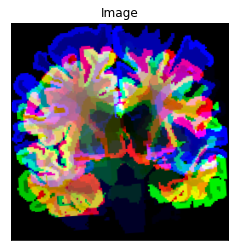

In [14]:
chosen_image = 0
for batch in train_aug_generator:
    chosen_image = batch[0][0]
    print(batch[1])
    break

chosen_image = cv2.resize(chosen_image, (256, 256), cv2.INTER_AREA)

showImage(chosen_image, "Image")
chosen_image = np.expand_dims(chosen_image, axis=0)

In [15]:
prediction = new_model.predict(chosen_image)
print(prediction)

print("class: {}".format(np.argmax(prediction[0])))

img_output = new_model.output[:, 0]
print(np.array(img_output))
last_conv_layer = new_model.get_layer('block5_conv3')
print(last_conv_layer.output)

[[0.09509972]]
class: 0
Tensor("strided_slice:0", shape=(?,), dtype=float32)
Tensor("block5_conv3_1/Relu:0", shape=(?, 16, 16, 512), dtype=float32)


In [16]:
last_conv_layer.output

<tf.Tensor 'block5_conv3_1/Relu:0' shape=(?, 16, 16, 512) dtype=float32>

In [17]:
gradients = K.gradients(img_output, last_conv_layer.output)[0]
print(gradients)

pooled_grads = K.mean(gradients, axis=(0, 1, 2))

iterate = K.function([new_model.input],
                    [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([chosen_image])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

Tensor("gradients/block5_pool_1/MaxPool_grad/MaxPoolGrad:0", shape=(?, 16, 16, 512), dtype=float32)


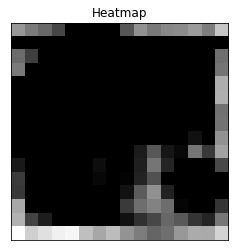

In [18]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
showImage(heatmap, "Heatmap")

## Overlay Heatmap to Image

(256, 256, 3)


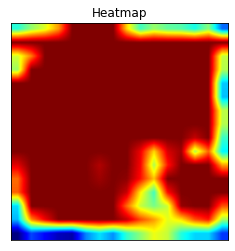

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


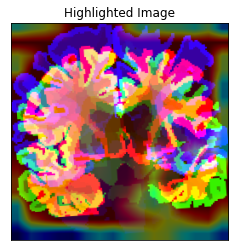

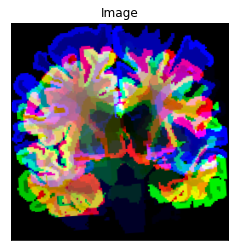

In [19]:
heatmap = cv2.resize(heatmap, (chosen_image.shape[2], chosen_image.shape[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print(heatmap.shape)
superimposed_img = heatmap * 0.0017 + chosen_image[0]

showImage(heatmap, "Heatmap")
showImage(superimposed_img, "Highlighted Image")
showImage(chosen_image[0], "Image")